In [41]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)


In [42]:
# Load MNIST dataset
(x_train, t_train), (x_test, t_test) = keras.datasets.mnist.load_data()

# Flatten 28x28 images into 784-length vectors
x_train = x_train.reshape(x_train.shape[0], -1).astype(np.float32) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype(np.float32) / 255.0

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels].astype(np.float32)

t_train_onehot = one_hot_encode(t_train)
t_test_onehot = one_hot_encode(t_test)

# Validation split (optional)
val_size = 5000
x_val = x_train[-val_size:]
t_val_onehot = t_train_onehot[-val_size:]
x_train_ = x_train[:-val_size]
t_train_onehot_ = t_train_onehot[:-val_size]

print("Training set:", x_train_.shape)
print("Validation set:", x_val.shape)
print("Test set:", x_test.shape)


Training set: (55000, 784)
Validation set: (5000, 784)
Test set: (10000, 784)


In [49]:
# Softmax activation
def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y_pred, y_true, l2_reg=0.0, W=None):
    eps = 1e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / N
    if l2_reg and W is not None:
        loss += 0.5 * l2_reg * np.sum(W * W)
    return loss

# Accuracy
def compute_accuracy(y_pred, y_true):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

# Initialize weights
input_size = 784
num_classes = 10
W = np.random.randn(input_size, num_classes) * 0.01
b = np.zeros((1, num_classes), dtype=np.float32)

# Forward pass
def forward_pass(X, W, b):
    Z = np.dot(X, W) + b
    return softmax(Z)

# Backward pass (gradient descent)
def backward_pass(X, Y, T, W, b, lr=0.1, l2_reg=0.0):
    N = X.shape[0]
    dZ = (Y - T) / N
    dW = X.T.dot(dZ)
    db = np.sum(dZ, axis=0, keepdims=True)
    if l2_reg:
        dW += l2_reg * W
    W -= lr * dW
    b -= lr * db
    return W, b


In [50]:
# Hyperparameters
learning_rate = 0.009
batch_size = 128
epochs = 60
l2_reg = 1e-4

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    indices = np.arange(x_train_.shape[0])
    np.random.shuffle(indices)
    x_shuf = x_train_[indices]
    t_shuf = t_train_onehot_[indices]

    for start in range(0, x_shuf.shape[0], batch_size):
        X_batch = x_shuf[start:start+batch_size]
        T_batch = t_shuf[start:start+batch_size]
        Y_batch = forward_pass(X_batch, W, b)
        W, b = backward_pass(X_batch, Y_batch, T_batch, W, b, lr=learning_rate, l2_reg=l2_reg)

    # Evaluate after each epoch
    Y_train = forward_pass(x_train_, W, b)
    train_loss = cross_entropy_loss(Y_train, t_train_onehot_, l2_reg=l2_reg, W=W)
    train_acc = compute_accuracy(Y_train, t_train_onehot_)

    Y_val = forward_pass(x_val, W, b)
    val_loss = cross_entropy_loss(Y_val, t_val_onehot, l2_reg=l2_reg, W=W)
    val_acc = compute_accuracy(Y_val, t_val_onehot)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

print(" Training completed successfully!")


Epoch 01/60 | Train Loss: 0.8981 | Train Acc: 83.02% | Val Acc: 87.28%
Epoch 05/60 | Train Loss: 0.5023 | Train Acc: 87.44% | Val Acc: 90.70%
Epoch 10/60 | Train Loss: 0.4234 | Train Acc: 88.86% | Val Acc: 91.66%
Epoch 15/60 | Train Loss: 0.3901 | Train Acc: 89.51% | Val Acc: 92.04%
Epoch 20/60 | Train Loss: 0.3706 | Train Acc: 89.94% | Val Acc: 92.32%
Epoch 25/60 | Train Loss: 0.3575 | Train Acc: 90.28% | Val Acc: 92.58%
Epoch 30/60 | Train Loss: 0.3477 | Train Acc: 90.49% | Val Acc: 92.86%
Epoch 35/60 | Train Loss: 0.3403 | Train Acc: 90.67% | Val Acc: 92.84%
Epoch 40/60 | Train Loss: 0.3342 | Train Acc: 90.80% | Val Acc: 93.00%
Epoch 45/60 | Train Loss: 0.3291 | Train Acc: 90.94% | Val Acc: 93.10%
Epoch 50/60 | Train Loss: 0.3249 | Train Acc: 91.06% | Val Acc: 93.12%
Epoch 55/60 | Train Loss: 0.3213 | Train Acc: 91.16% | Val Acc: 93.10%
Epoch 60/60 | Train Loss: 0.3181 | Train Acc: 91.27% | Val Acc: 93.12%
 Training completed successfully!


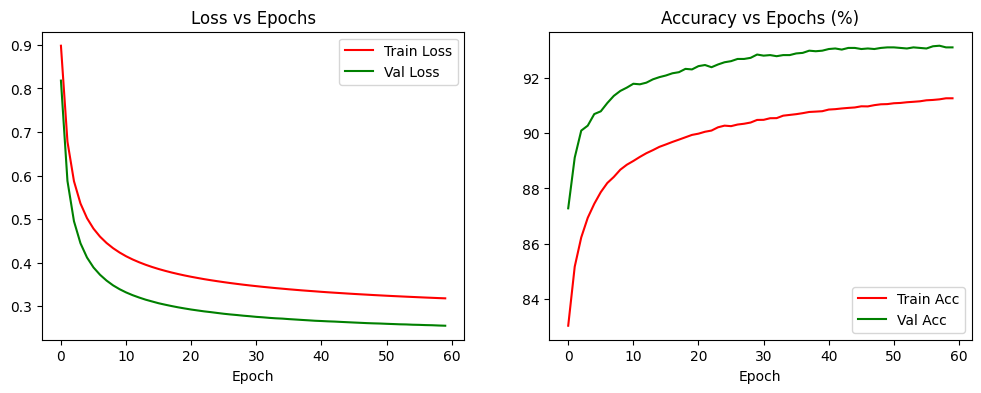

In [53]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss',c='red')
plt.plot(val_losses, label='Val Loss',c='green')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot([a*100 for a in train_accuracies], label='Train Acc',c='red')
plt.plot([a*100 for a in val_accuracies], label='Val Acc',c='green')
plt.title("Accuracy vs Epochs (%)")
plt.xlabel("Epoch")
plt.legend()

plt.show()



Final Test Accuracy: 91.79%


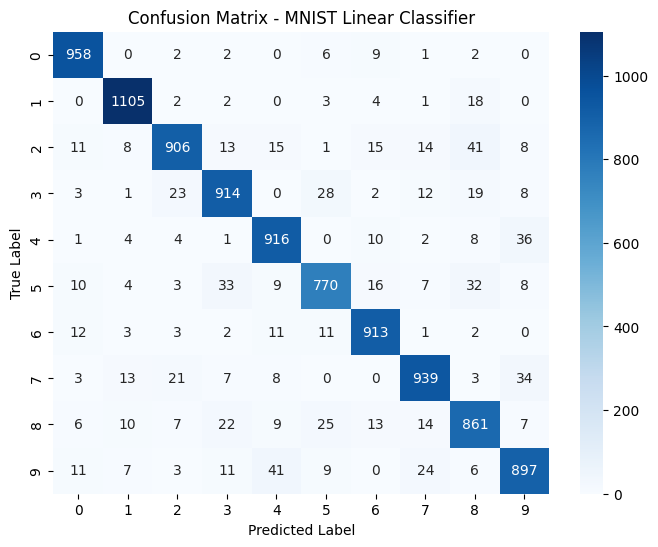

Classification Report:
              precision    recall  f1-score   support

           0     0.9438    0.9776    0.9604       980
           1     0.9567    0.9736    0.9651      1135
           2     0.9302    0.8779    0.9033      1032
           3     0.9076    0.9050    0.9063      1010
           4     0.9078    0.9328    0.9201       982
           5     0.9027    0.8632    0.8825       892
           6     0.9297    0.9530    0.9412       958
           7     0.9251    0.9134    0.9192      1028
           8     0.8679    0.8840    0.8759       974
           9     0.8988    0.8890    0.8939      1009

    accuracy                         0.9179     10000
   macro avg     0.9171    0.9169    0.9168     10000
weighted avg     0.9178    0.9179    0.9177     10000



In [54]:
# Forward pass on test set
Y_test_pred = forward_pass(x_test, W, b)
test_acc = compute_accuracy(Y_test_pred, t_test_onehot)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# Confusion matrix
y_true = np.argmax(t_test_onehot, axis=1)
y_pred = np.argmax(Y_test_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MNIST Linear Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


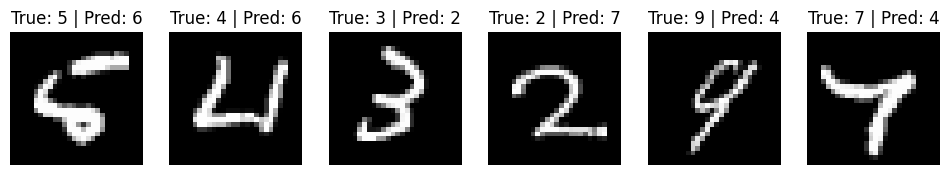

In [55]:
# MISCLASSIFIED IMAGES
mis_idx = np.where(y_true != y_pred)[0]
n_show = 6
plt.figure(figsize=(12,4))
for i, idx in enumerate(mis_idx[:n_show]):
    plt.subplot(1, n_show, i+1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
    plt.axis('off')
plt.show()


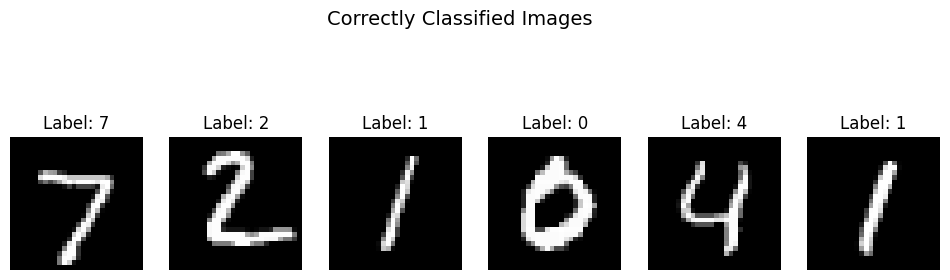

In [59]:
# CLASSIFIED

y_true = np.argmax(t_test_onehot, axis=1)
y_pred = np.argmax(Y_test_pred, axis=1)

correct_idx = np.where(y_true == y_pred)[0]

n_show = 6
plt.figure(figsize=(12, 4))
plt.suptitle("Correctly Classified Images", fontsize=14)

for i, idx in enumerate(correct_idx[:n_show]):
    plt.subplot(1, n_show, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_true[idx]}")
    plt.axis('off')

plt.show()


# ANALYSIS:
After training the multiclass linear classifier (softmax + cross-entropy) for 60 epochs with mini-batch gradient descent and a small L2 regularization (λ = 1e−4), the model achieved a test accuracy of 91.79% . Training and validation loss curves demonstrate convergence without severe overfitting. The confusion matrix highlights that the model sometimes confuses similar-shaped digits (for example 4 vs 9, or 3 vs 5). Overall the linear model obtains competitive accuracy (~85–91%) with a simple, fully-vectorized NumPy implementation.